<h1> MIDS W207 Final</h1>

<h3> Group Members </h3>
Ben Attix <br>
Justin Plumley <br>
Dan Watson

<h3> Kaggle Competition </h3>
Zillow Prize: Zillow’s Home Value Prediction (Zestimate)

<h3> Evaluation </h3>
Submissions are evaluated on Mean Absolute Error between the predicted log error and the actual log error. The log error is defined as:
logerror=log(Zestimate)−log(SalePrice)
and it is recorded in the transactions training data. If a transaction didn't happen for a property during that period of time, that row is ignored and not counted in the calculation of MAE.

<h5> Competition Website </h5>
https://www.kaggle.com/c/zillow-prize-1#description

<h2> Load libraries, data, and test output

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# General libraries.
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
color = sns.color_palette()
import time
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.mplot3d import Axes3D


# preprocessing
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import OneHotEncoder

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from sklearn.mixture import GaussianMixture 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor 


# SK-learn libraries for evaluation.
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
train_csv = pd.read_csv("train_2016_v2.csv", parse_dates=["transactiondate"])
prop_df = pd.read_csv("properties_2016.csv")
print prop_df.shape 
print train_csv.shape
#df outputs
#prop_df.head()
#train_df.head()

(2985217, 58)
(90275, 3)


In [51]:
train_csv.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


<H2> EDA </H2> <br>
Many ideas and code taken from following EDA Kernels:
https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-zillow-prize (python)
https://www.kaggle.com/philippsp/exploratory-analysis-zillow (R)
https://www.kaggle.com/captcalculator/a-very-extensive-zillow-exploratory-analysis (R)
https://www.kaggle.com/viveksrinivasan/zillow-eda-on-missing-values-multicollinearity (python)

<H5> Start by looking at the parcelIDs that occur in each dataset </H5>

In [ ]:
# start by looing at unique parcelIDs
print "Unique ParcelIDs in train_df:", train_csv.parcelid.nunique()
print "Unique ParcelIDs in prop_df:", prop_df.parcelid.nunique()

We have 2,985,217 parcel IDs in the properties data but only 90,150 in the training data. When training our model, the only parcel IDs we can use are the ones both datasets, the rest are useless to us.

By doing an inner merge we can limit our data down to the parcel IDs we want.

In [3]:
# merge dataframes and view result
train_df = pd.merge(train_csv, prop_df, on='parcelid', how='inner')
print 'Dataframe shape:', train_df.shape
train_df.head()

Dataframe shape: (90275, 60)


,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,4.0,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1.0,NaN,NaN,3.0,2.0,NaN,4.0,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,1.0,NaN,NaN,2.0,2.0,NaN,4.0,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,NaN,NaN,NaN,2.5,4.0,NaN,NaN,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13


In [ ]:
train_df.describe()

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.logerror.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

Log error is quite good for vast majority- outliers are key here

In [ ]:
plt.figure(figsize=(12,8))
sns.distplot(train_df.logerror.values, bins=50, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.show()

Seems liked a peaked distribution, but outliers on log error are affecting the histogram.  Removing outliers:

<H5> Transaction Date </H5>

In [ ]:
train_df.transactiondate.describe()

All the data is from 2016- we can aggregate it by month

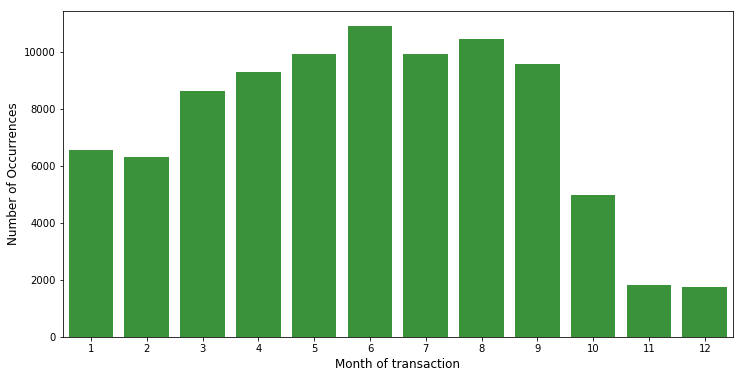

In [4]:
train_df['transaction_month'] = train_df['transactiondate'].dt.month

cnt_srs = train_df['transaction_month'].value_counts()
plt.figure(figsize=(12,6))
bars= sns.barplot(cnt_srs.index, cnt_srs.values,  color=color[2])
plt.xticks()
plt.xlabel('Month of transaction', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()

Slow start of the year, then transactions pick up through August.  We do not have all the transactions after October 15th, per competition website.

In [ ]:
sns.set_style("whitegrid")
s1_dims = (15, 20)
fig, ax = plt.subplots(figsize=s1_dims)
ax.set(ylim=(-0.2, 0.2))
sns.violinplot(ax=ax, data=train_df, x="transaction_month", y="logerror")

Variance appears to grow with the later months (those with fewer values), though the medians appear to be positive, particularly for the winter months.  Besides normal features, we may want to include dummy variables for seasonality.


<h5> Parcel ID </h5>

In [ ]:
train_df['parcelid'].value_counts().reset_index()['parcelid'].value_counts()

Only 124 of the 90k+ properties had multiple transactions in this year period

<H5> Onto the Properties 2016 file <H5>

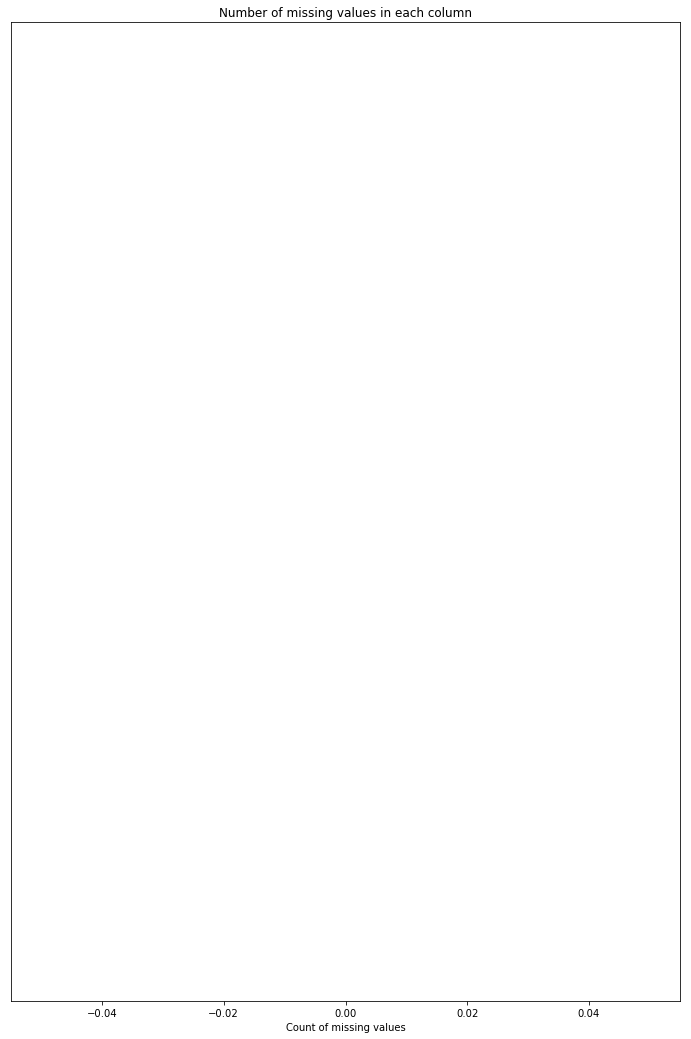

In [45]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.ix[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

In [ ]:
# How much of your data is missing?
train_df.isnull().sum().sort_values(ascending=False).head()

In [5]:
# df = df.drop('column_name', 1)
to_drop = ['architecturalstyletypeid'
           ,'assessmentyear'
           ,'bathroomcnt'
           ,'buildingclasstypeid'
           ,'decktypeid'
           ,'threequarterbathnbr'
           ,'finishedfloor1squarefeet'
           ,'finishedsquarefeet6'
           ,'finishedsquarefeet12'
           ,'finishedsquarefeet13'
           ,'finishedsquarefeet15'
           ,'finishedsquarefeet50'
           ,'fireplaceflag'
           ,'fullbathcnt'
           ,'garagetotalsqft'
           ,'latitude'
           ,'longitude'
           ,'poolsizesum'
           ,'propertyzoningdesc'
           ,'rawcensustractandblock'
           ,'censustractandblock'
           ,'regionidzip'
           ,'storytypeid'
           ,'typeconstructiontypeid'
           ,'taxvaluedollarcnt'
           ,'taxamount'
           ,'taxdelinquencyyear'
           ,'fips'
           
           ,'hashottuborspa'
           ,'pooltypeid10'
           ,'pooltypeid2'
           ,'pooltypeid7'
               
           ,'propertycountylandusecode'   # 241 unique values, cannot dummy for size reasons          
           ,'regionidcity'            # 187 unique values, cannot dummy for size reasons
           ,'regionidneighborhood'    # 529 unique values, cannot dummy for size reasons
           ,'transactiondate'
          ]

for col in to_drop:
    train_df = train_df.drop(col,1)

In [6]:
##df['bedroomcnt'] = [0 if x <3 else 1 for x in df['bedroomcnt']] #bad example, but you get the point
# Bin object variables in specific ways

## airconditioningtypeid
train_df['airconditioningtypeid'].fillna(value='missing',inplace=True)

## bedroomcnt
a = np.array(train_df['bedroomcnt'].values.tolist())
train_df['bedroomcnt'] = np.where(a > 6, 6, a).tolist()
train_df['bedroomcnt'].fillna(value=3,inplace=True) # Or maybe impute with most_common, which is 3

## buildingqualitytypeid (best=lowest, worse=highest)

a = np.array(train_df['buildingqualitytypeid'].values.tolist())
train_df['buildingqualitytypeid'] = np.where(a < 4,  4, a)  #.tolist()
a = np.array(train_df['buildingqualitytypeid'].values.tolist())
train_df['buildingqualitytypeid'] = np.where(a > 7, 10, a)  #.tolist()
a = np.array(train_df['buildingqualitytypeid'].values.tolist())
train_df['buildingqualitytypeid'] = np.where(a == 5, 7, a)  #.tolist()
a = np.array(train_df['buildingqualitytypeid'].values.tolist())
train_df['buildingqualitytypeid'] = np.where(a == 6, 7, a).tolist()
a = np.array(train_df['buildingqualitytypeid'].values.tolist())
train_df['buildingqualitytypeid'].fillna(value=99,inplace=True) # 99 = missing (BE CAREFUL NOT TO CHANGE BEFORE '>' STATEMENT)

## fips - we dropped this so no need to proprocess
# train_df['fips'].fillna(value=99,inplace=True)

## fireplacecnt
a = np.array(train_df['fireplacecnt'].values.tolist())
train_df['fireplacecnt'] = np.where(a > 3,  3, a)  #.tolist()
train_df['fireplacecnt'].fillna(value=0,inplace=True) #set NaN to zero

## garagecarcnt
a = np.array(train_df['garagecarcnt'].values.tolist())
train_df['garagecarcnt'] = np.where(a > 3,  3, a)  #.tolist()
train_df['garagecarcnt'].fillna(value=99,inplace=True) #set NaN to 99

##  hashottuborspa
#train_df['hashottuborspa'].fillna(value=False,inplace=True) #set NaN to False

## heatingorsystemtypeid
a = np.array(train_df['heatingorsystemtypeid'].values.tolist())
train_df['heatingorsystemtypeid'] = np.where(a == 19,  14, a)  #.tolist()
a = np.array(train_df['heatingorsystemtypeid'].values.tolist())
train_df['heatingorsystemtypeid'] = np.where(a == 21, 14, a)  #.tolist()
a = np.array(train_df['heatingorsystemtypeid'].values.tolist())
train_df['heatingorsystemtypeid'] = np.where(a == 11, 14, a)  #.tolist()
a = np.array(train_df['heatingorsystemtypeid'].values.tolist())
train_df['heatingorsystemtypeid'] = np.where(a == 12, 14, a)  #.tolist()
a = np.array(train_df['heatingorsystemtypeid'].values.tolist())
train_df['heatingorsystemtypeid'] = np.where(a == 10, 14, a)  #.tolist()
a = np.array(train_df['heatingorsystemtypeid'].values.tolist())
train_df['heatingorsystemtypeid'] = np.where(a ==  1, 14, a)  #.tolist()
a = np.array(train_df['heatingorsystemtypeid'].values.tolist())
train_df['heatingorsystemtypeid'] = np.where(a == 18, 14, a)  #.tolist()
a = np.array(train_df['heatingorsystemtypeid'].values.tolist())
train_df['heatingorsystemtypeid'] = np.where(a == 13, 14, a)  #.tolist()
a = np.array(train_df['heatingorsystemtypeid'].values.tolist())
train_df['heatingorsystemtypeid'] = np.where(a == 20, 14, a)  #.tolist()
a = np.array(train_df['heatingorsystemtypeid'].values.tolist())
train_df['heatingorsystemtypeid'] = np.where(a == 12, 14, a).tolist()
a = np.array(train_df['heatingorsystemtypeid'].values.tolist())

train_df['heatingorsystemtypeid'].fillna(value=99,inplace=True) #set NaN to 99

## numberofstories
a = np.array(train_df['numberofstories'].values.tolist())
train_df['numberofstories'] = np.where(a > 3,  3, a)  #.tolist()
train_df['numberofstories'].fillna(value=99,inplace=True) #set NaN to 99

## poolcnt
train_df['poolcnt'].fillna(value=0,inplace=True) #set NaN to zero

## pooltypes
#train_df['pooltypeid10'].fillna(value=0,inplace=True) #set NaN to zero
#train_df['pooltypeid2'].fillna(value=0,inplace=True) #set NaN to zero
#train_df['pooltypeid7'].fillna(value=0,inplace=True) #set NaN to zero


## propertycountylandusecode
#### probably should loop through, has 241 distinct values, some of which have count=1
#train_df['propertycountylandusecode'].fillna(value=99,inplace=True) #set NaN to 99

## propertylandusetypeid
### too many unique values, so had to drop
train_df['propertylandusetypeid'].fillna(value=99,inplace=True) #set NaN to 99

## regionidcounty
train_df['regionidcounty'].fillna(value=99,inplace=True) #set NaN to 99

## regionidcity
#### probably should loop through, has 187 distinct values, some of which have count=1
### too many unique values, so had to drop
#train_df['regionidcity'].fillna(value=99,inplace=True) #set NaN to 99

## regionidneighborhood
#### probably should loop through, has 500+ distinct values, some of which have count=1.  Maybe use lat-long to KNN???
### too many unique values, so had to drop
#train_df['regionidneighborhood'].fillna(value=99,inplace=True) #set NaN to 99

## calculatedbathnbr
train_df['calculatedbathnbr'].fillna(value=2,inplace=True)  # Or maybe impute with most_common, which is 2

## roomcnt
a = np.array(train_df['roomcnt'].values.tolist())
train_df['roomcnt0'] = np.where(a == 0, 1, 0)  #.tolist()
train_df['roomcnt'] = np.where(a < 3,  3, a)  #.tolist()
a = np.array(train_df['roomcnt'].values.tolist())
train_df['roomcnt'] = np.where(a > 7, 10, a)  #.tolist()
a = np.array(train_df['roomcnt'].values.tolist())
train_df['roomcnt'] = np.where(a == 5, 7, a)  #.tolist()
a = np.array(train_df['roomcnt'].values.tolist())
train_df['roomcnt'] = np.where(a == 6, 7, a).tolist()
a = np.array(train_df['roomcnt'].values.tolist())
train_df['roomcnt'].fillna(value=6,inplace=True) #set NaN to 6, most common value


## unitcnt
a = np.array(train_df['unitcnt'].values.tolist())
train_df['unitcnt'] = np.where(a > 5, 5, a)  #.tolist()
train_df['unitcnt'].fillna(value=1,inplace=True) #set NaN to 1

## yearbuilt    
a = np.array(train_df['yearbuilt'].values.tolist())
train_df['yearbuilt'] = (train_df['yearbuilt']/10).round()
a = np.array(train_df['yearbuilt'].values.tolist())
train_df['yearbuilt'] = np.where(a < 190, 189, a)  #.tolist()
train_df['yearbuilt'].fillna(value=195,inplace=True) #set NaN to 195



##  taxdelinquencyflag   train_df['taxdelinquencyflag'].value_counts()
train_df['taxdelinquencyflag'] = [1 if x == 'Y' else 0 for x in train_df['taxdelinquencyflag']] 
train_df['taxdelinquencyflag'].fillna(value=0,inplace=True) #set NaN to zeroTrue) #set NaN to zero


##  Numeric variables whose NaN we'll set to zero
a = np.array(train_df['basementsqft'].values.tolist())
train_df['basementsqft_NaN'] = np.where(a == np.NaN, 1, 0)  #.tolist()
train_df['basementsqft'].fillna(value=0,inplace=True) #set NaN to zero

a = np.array(train_df['calculatedfinishedsquarefeet'].values.tolist())
train_df['calculatedfinishedsquarefeet_NaN'] = np.where(a == np.NaN, 1, 0)  #.tolist()
train_df['calculatedfinishedsquarefeet'].fillna(value=0,inplace=True) #set NaN to zero

a = np.array(train_df['lotsizesquarefeet'].values.tolist())
train_df['lotsizesquarefeet_NaN'] = np.where(a == np.NaN, 1, 0)  #.tolist()
train_df['lotsizesquarefeet'].fillna(value=0,inplace=True) #set NaN to zero

a = np.array(train_df['yardbuildingsqft17'].values.tolist())
train_df['yardbuildingsqft17_NaN'] = np.where(a == np.NaN, 1, 0)  #.tolist()
train_df['yardbuildingsqft17'].fillna(value=0,inplace=True) #set NaN to zero
a = np.array(train_df['yardbuildingsqft17'].values.tolist())
train_df['yardbuildingsqft17'] = np.where(a > 0, 1, 0)  #.tolist()

a = np.array(train_df['yardbuildingsqft26'].values.tolist())
train_df['yardbuildingsqft26_NaN'] = np.where(a == np.NaN, 1, 0)  #.tolist()
train_df['yardbuildingsqft26'].fillna(value=0,inplace=True) #set NaN to zero
a = np.array(train_df['yardbuildingsqft26'].values.tolist())
train_df['yardbuildingsqft26'] = np.where(a > 0, 1, 0)  #.tolist()

a = np.array(train_df['structuretaxvaluedollarcnt'].values.tolist())
train_df['structuretaxvaluedollarcnt_NaN'] = np.where(a == np.NaN, 1, 0)  #.tolist()
train_df['structuretaxvaluedollarcnt'].fillna(value=0,inplace=True) #set NaN to zero

a = np.array(train_df['landtaxvaluedollarcnt'].values.tolist())
train_df['landtaxvaluedollarcnt_NaN'] = np.where(a == np.NaN, 1, 0)  #.tolist()
train_df['landtaxvaluedollarcnt'].fillna(value=10000,inplace=True) #set NaN to 10000

a = np.array(train_df['calculatedfinishedsquarefeet'].values.tolist())
train_df['calculatedfinishedsquarefeet_NaN'] = np.where(a == np.NaN, 1, 0)  #.tolist()
train_df['calculatedfinishedsquarefeet'].fillna(value=6000,inplace=True) #set NaN to 6000, most common number



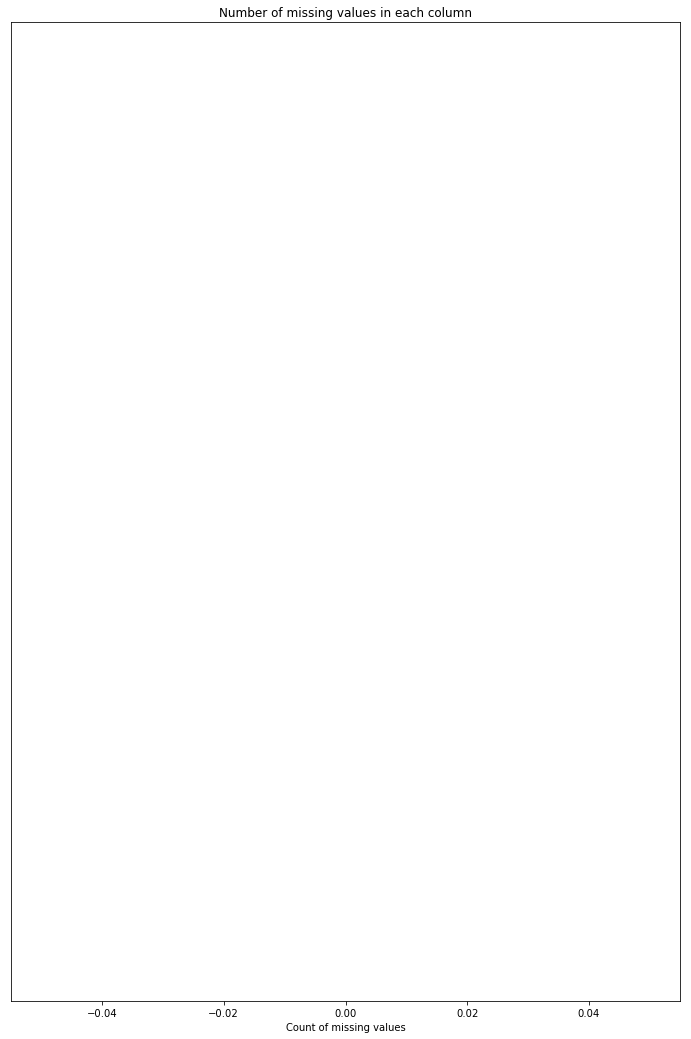

In [60]:
# Check Missing values again, after processing attempt to remove some fields and assign a value to others' NaN values
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.ix[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

In [7]:

objs = [ 'airconditioningtypeid'
        ,'bedroomcnt'
        ,'buildingqualitytypeid'
        ,'fireplacecnt'
        ,'garagecarcnt'
        ,'heatingorsystemtypeid'
        ,'numberofstories'
        ,'poolcnt'        
        ,'propertylandusetypeid'   
        ,'regionidcounty'
        ,'unitcnt'
        ,'yearbuilt'   
        ,'taxdelinquencyflag'  
        ,'yardbuildingsqft17'
        ,'yardbuildingsqft26'        
        ]


for obj in objs:
    train_df[obj] = train_df[obj].astype(object)

In [8]:

flts = [ 'basementsqft'
        ,'calculatedbathnbr'
        ,'calculatedfinishedsquarefeet'
        ,'landtaxvaluedollarcnt'
        ,'lotsizesquarefeet'
        ,'roomcnt'
        ,'structuretaxvaluedollarcnt'
       ]

for flt in flts:
    train_df[flt] = train_df[flt].astype(float)

In [9]:
# Decide which categorical variables you want to use in model
for col in train_df.columns:
    if train_df[col].dtypes == 'object':       
        unique_cat = len(train_df[col].unique())
        print("Feature '{col_name}' has {unique_cat} unique categories".format(col_name=col, unique_cat=unique_cat))

Feature 'airconditioningtypeid' has 7 unique categories
Feature 'bedroomcnt' has 7 unique categories
Feature 'buildingqualitytypeid' has 4 unique categories
Feature 'fireplacecnt' has 4 unique categories
Feature 'garagecarcnt' has 5 unique categories
Feature 'heatingorsystemtypeid' has 6 unique categories
Feature 'poolcnt' has 2 unique categories
Feature 'propertylandusetypeid' has 14 unique categories
Feature 'regionidcounty' has 3 unique categories
Feature 'unitcnt' has 5 unique categories
Feature 'yardbuildingsqft17' has 2 unique categories
Feature 'yardbuildingsqft26' has 2 unique categories
Feature 'yearbuilt' has 14 unique categories
Feature 'numberofstories' has 4 unique categories
Feature 'taxdelinquencyflag' has 2 unique categories


In [10]:
# Create dummy list
to_dummy = [ 'airconditioningtypeid'
            ,'bedroomcnt'
            ,'buildingqualitytypeid'
            ,'fireplacecnt'
            ,'garagecarcnt'
            ,'heatingorsystemtypeid'
            ,'numberofstories'
            ,'poolcnt'
            ,'propertylandusetypeid'   
            ,'regionidcounty'         
            ,'unitcnt'
            ,'yearbuilt'   
            ,'taxdelinquencyflag'  
            ,'yardbuildingsqft17'
            ,'yardbuildingsqft26'   
            ,'transaction_month'
            ]

In [11]:
# Use this function to dummy all the categorical variables we want to keep
def dummy_df(df, todummy_list):
    for x in todummy_list:       
        dummies = pd.get_dummies(df[x], prefix=x, dummy_na=True)
        df = df.drop(x, 1)
        df = pd.concat([df, dummies], axis=1)
    return df

In [12]:
## bool  
train_df = dummy_df(train_df, to_dummy)

<h2> Analysis into Extreme Log Errors </h2>


This competition is focused on predicting the log error of predicted versus transaction prices. As shown in the graph in EDA section and recreated below, the vast majority of log errors are quite low. It is in the extreme values where the error rates increase drastically. Therefore, we will perform an analysis on just these extreme values to see if there are any patterns that will help us identify these values.

In [ ]:
plt.figure(figsize=(8,5))
# create a mask for values less than -.1 and greater than .1
masked = np.ma.masked_outside(np.sort(train_df.logerror.values), -.1, .1)
# plot masked and non-masked values
plt.plot(range(train_df.shape[0]), np.sort(train_df.logerror.values), 'red')
plt.plot(range(train_df.shape[0]), masked, 'blue')
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

In [ ]:
high_error_df= train_df[(train_df.logerror <-.1) | (train_df.logerror >.1)]
low_error_df = train_df[(train_df.logerror>=-.1) & (train_df.logerror<=.1)]

First we'll visualize the log errors by month of transaction to see if there are any seasonal effects.

In [ ]:
cnt_srs = high_error_df['transaction_month'].value_counts()
plt.figure(figsize=(12,6))
bars= sns.barplot(cnt_srs.index, cnt_srs.values,  color=color[2])
plt.xticks()
plt.xlabel('Month of transaction', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.title('Number of Transactions per Month- High Error Data')
plt.show()



cnt_srs = low_error_df['transaction_month'].value_counts()
plt.figure(figsize=(12,6))
bars= sns.barplot(cnt_srs.index, cnt_srs.values,  color=color[2])
plt.xticks()
plt.xlabel('Month of transaction', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.title('Number of Transactions per Month- All Data')
plt.show()

These charts tend to follow the same pattern

In [ ]:
high_error_df.ix[:, 0:10].describe()

In [ ]:
low_error_df.ix[:, 0:10].describe()

Reviewing the differences in the high errors and low errors dataframes, we observe the following differences:

__Calculated Finished Square Feet:__ The low error transactions have a mean value of 1739 sqft with a standard deviation of 876sqft.  The high error transactions have a high mean value of 1870 sqft with a higher standard deviation of 1197. 

<b> Structure Tax Value Dollar Count </b> The high error transactions have a higher mean (192253 vs 176848) and a higher standard deviation (310239 vs 183111) than low error transactions.

<b> Land Tax Value Dollar Count </b> Similar to the structure tax value dollar count, the mean land value dollar count is higher for high error transactions (322560 vs 269816) and has a higher standard deviation (641348 vs 334122).

<b> FIPS </b> The FIPS indicates the county of the home.  In the high error data, 73.8% of the homes are in Los Angeles County, 19% are in Orange County, and 6.7% are in Ventura County.  In the low error data, 63% are in Los Angeles County, 28% are in Orange County, and 8.2% are in Ventura County.

<h2> K-Nearest Neighbors </h2>

K-Nearest Neighbors is a classification model which predicts the classification of an unclassified data point based upon the values of it's closest k neighbors. Therefore, when k=1, the model will predict the value based upon the cloest neighbor. When k= 9, the model will find the new data points 9 closest neighbors and determine the majority classification of those nine points. The majority classification will be imputed to the unclassified data point.
Here, we are attempting to classify whether an property value will result in a large positive error, a low error, or a large negative error. By classifying the type of error, we can help direct our final model towards a specific predicted error value, thus lowering the MAE.

In [ ]:
#Create a copy of the train_data so that we cam make changes
classifier_data = train_df.copy()

classifier_data['logerror'].loc[classifier_data['logerror']>=.1] = 1
classifier_data['logerror'].loc[classifier_data['logerror']<= -.1] = -1
classifier_data['logerror'].loc[(classifier_data['logerror']>-.1) & (classifier_data['logerror']<.1)] = 0

train_np = classifier_data.values
Y = train_np[:,0]
Y.flatten()
X =train_np[:,1:]

shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape: ', Y.shape)

# Set some variables to hold test, dev, and training data.
classifier_test_data, classifier_test_labels = X[70000:], Y[70000:]
classifier_train_data, classifier_train_labels = X[:70000], Y[:70000]

In [ ]:
#Originally ran with k values range (1,200,20), but little to no increase after k>20
k_values = range(10,32, 2)
for k in k_values:
    #initialize and train the classifier
    clf = KNeighborsClassifier(n_neighbors = k)
    clf.fit(classifier_train_data, classifier_train_labels)
    accuracy= clf.score(classifier_test_data, classifier_test_labels)
    predictions = clf.predict(classifier_test_data)
    
    #Uncomment code below and comment out if statement above to get classification report for all k values
#     print("Classification Report for k =" + str(k))
#     print(classification_report(knn_test_labels.astype(int),predictions))
# For all k values, print the accuracy
    print("K: " + str(k) + " Accuracy: " + str(accuracy))
    if k == 30:
        print("Classification Report for k = {}".format(k))
        print(classification_report(classifier_test_labels.astype(int),predictions))

<b>Results: </b> While the accuracy of this model in classifying whether the outcome will be a large positive error (1), a low error (0), or a large negative error(-1) is approximately 84%, this K-Nearest Neighbors classifier performance is quite poor. The printed classification report is for the k=1 model, but the reports for higher k models show the same general issues  

The precision column indicates the positive predictive value, which is calculated by the number of true positives divided by the number of true positives plus false positives.  In our situation, the precision measures the percentage of predictions that our model predicted to be 1s that were actually 1s.  As you can see, the precision of this model is low at 25% values that extreme highs and 0% for extreme lows.  This classifier performs very poorly for precision. 

The recall column indicates the sensitivity of the model.  It is calculated by taking the ratio of true positive results divided by the sum of true positives and false negatives.  In this situation, recall measures the percentage of 1s that our model identifies out of all 1s it should have identified. In our model, the recall is 0% for the extreme log errors that we are trying to classify.  

The f1-score is the weighted harmonic mean of the precision and recall and gives an understanding of the overall power of the classifier. 

Due to the relatively small amount of extreme results in our data, this classifier tends to overpredict results of 0.  As a result, we end up with high accuracy, but poor precision and recall.  Therefore, we will not add the results of this classifier into our dataset for our final model.

# Naive Bayes

<h2> Naive Bayes </h2>

Naive Bayes methods are supervised learning algorithms that apply Bayes' Theorem with the assumption of independence between each pair of features.  While we know that we do not have independence between each pair of features in our data, in practice, Naive Bayes has worked well in datasets that violate this assumption.  

The SKLearn package supports three distinct Naive Bayes models.  The first is Gaussian Naive Bayes model.  This model assumes the likelihood of the features is distributed like a Gaussian, or normal, distribution.  The second supported model is the Multinomial Naive Bayes model.  The multinomial model is for multinomially distributed data and is best suited for data that can be turned into counts- such as text classification with word counts.  The final model is the Bernoulli Naive Bayes model, which is used with data distributed similar to a multivariate Bernoulli Distribution.  Each feature in a Bernoulli model is assumed to be binary.  

More information about SKLearn Naive Bayes models can be located here: http://scikit-learn.org/stable/modules/naive_bayes.html

Since our data can be best classified as normally distributed and is not binary and is not well suited for a multinomial distribution, we will use a Gaussian Naive Bayes model.

In [ ]:
#Initialize model and test accuracy of multinomial naive bayes classifier
gauss_nb = GaussianNB()
gauss_nb.fit(classifier_train_data, classifier_train_labels)
nb_accuracy = gauss_nb.score(classifier_test_data, classifier_test_labels)
print("Accuracy of Gaussian Naive Bayes Model: {}".format(round(nb_accuracy,3)))

In [ ]:
# trainknn= train_df.copy()
# #['airconditioningtypeid', 'parcelid','taxdelinquencyflag','transactiondate', 'propertycountylandusecode']

# ulimit = np.percentile(trainknn.logerror.values, 99)
# llimit = np.percentile(trainknn.logerror.values, 1)
# trainknn['logerror'].loc[trainknn['logerror']>=ulimit] = 1
# trainknn['logerror'].loc[trainknn['logerror']<=llimit] = -1
# trainknn['logerror'].loc[(trainknn['logerror']>llimit) & (trainknn['logerror']<ulimit)] = 0

# train_np = trainknn.values
# Y_knn = train_np[:,0]
# Y_knn.flatten()
# X_knn =train_np[:,1:]

# shuffle = np.random.permutation(np.arange(X_knn.shape[0]))
# X_knn, Y_knn = X_knn[shuffle], Y_knn[shuffle]

# print('data shape: ', X_knn.shape)
# print('label shape: ', Y_knn.shape)

# # Set some variables to hold test, dev, and training data.
# train_data_knn, train_labels_knn = X_knn[:50000], Y_knn[:50000]
# dev_data_knn, dev_labels_knn = X_knn[50000:70000], Y_knn[50000:70000]
# test_data_knn, test_labels_knn = X_knn[70000:], Y_knn[70000:]


# pca_knn = PCA(n_components=3)
# pca_knn.fit(train_data_knn)
# train_data_pca_knn = pca_knn.transform(train_data_knn) 
# dev_data_pca_knn = pca_knn.transform(dev_data_knn)

In [ ]:
# k_values = range(1,20)
# for i in k_values:
#     #initialize and train the classifier
#     clf = KNeighborsClassifier(n_neighbors = i)
#     clf.fit(train_data_pca_knn, train_labels_knn.astype(int))
#     accuracy= clf.score(dev_data_pca_knn, dev_labels_knn.astype(int))
#     predictions = clf.predict(dev_data_pca_knn)
#     ## if k = 1, then print the classification report
#     if i == 10:
#         print("Classification Report for k =" + str(i))
#         print(classification_report(dev_labels_knn.astype(int),predictions))
#     # For all k values, print the accuracy
#     print("K: " + str(i) + " Accuracy: " + str(accuracy))

<h2> ML Start </h2>

In [27]:
# split data into training and dev sets. We don't need test sets since that is done on the Kaggle website
train_np = train_df.values
Y = train_np[:,1]
Y.flatten()
X = train_np[:,2:]

shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape: ', Y.shape)

# Set some variables to hold test, dev, and training data.
train_data, train_labels = X[:70000], Y[:70000]
dev_data, dev_labels = X[70000:], Y[70000:]

#definite MAE (Mean Absolute Error) function
def MAE(test_labels, predictions):
    values = []
    for i in range(len(test_labels)):
        difference = abs(round(test_labels[i],6) - round(predictions[i],6))
        values.append(difference)
    mean_abs_error = round(sum(values)/len(values),7)
    return mean_abs_error

('data shape: ', (90275, 124))
('label shape: ', (90275,))


### Create Submission Dataset

In [66]:
properties_df = pd.read_csv("preprocessed_properties.csv")
print properties_df.shape

# convert to array and remove parcelIDs
properties_np = properties_df.values
parcelids = properties_np[:, 0]
props_to_model = properties_np[:, 1:]

# function to create Kaggle submission files 
def get_submission_file(parcelids, oct_est, nov_est, dec_est):
    submission_array = np.vstack((parcelids, oct_est, nov_est, dec_est, oct_est, nov_est, dec_est))

    submission_df = pd.DataFrame(submission_array.T)
    submission_df.rename(columns={0: 'ParcelId',
                                  1: '201610',
                                  2: '201611',
                                  3: '201612',
                                  4: '201710',
                                  5: '201711',
                                  6: '201712'
                                 }, inplace=True)
    
    submission_df["ParcelId"] = submission_df["ParcelId"].astype(int)
    submission_df.to_csv("Zillow_submission_file.csv", index = False)

(2985217, 112)


In [30]:
# create arrays to represent months Oct, Nov, Dec
# note: our months are dummy variables
rows = props_to_model.shape[0]
october = np.hstack((np.zeros((rows,9)), np.ones((rows,1)), np.zeros((rows,3))))
november = np.hstack((np.zeros((rows,10)), np.ones((rows,1)), np.zeros((rows,2))))
december = np.hstack((np.zeros((rows,11)), np.ones((rows,1)), np.zeros((rows,1))))

submission_setup_oct = np.hstack((props_to_model, october))
submission_setup_nov = np.hstack((props_to_model, november))
submission_setup_dec = np.hstack((props_to_model, december))

## Linear Regression Model

In [28]:
# Initialize model
lm = LinearRegression()
lm.fit(train_data, train_labels)
lm_predict = lm.predict(dev_data)

lm_mae = MAE(dev_labels, lm_predict)
print "Linear Regression gives us a Mean Absolute Error of", lm_mae

Linear Regression gives us a Mean Absolute Error of 0.068632


In [47]:
# predict final outputs
lm_subm_oct = lm.predict(submission_setup_oct)
lm_subm_nov = lm.predict(submission_setup_nov)
lm_subm_dec = lm.predict(submission_setup_dec)

(2985217, 7)


In [70]:
get_submission_file(parcelids, lm_subm_oct, lm_subm_nov, lm_subm_dec)

## Gradient Boosting

In [ ]:
estimators = range(5,30)
lowest_mae = 1
results = []
for i in estimators:
    gboost = GradientBoostingRegressor(n_estimators=i) 
    gboost.fit(train_data, train_labels)
    gboost_predict = gboost.predict(dev_data)

    mae = MAE(dev_labels, gboost_predict)
    results.append(mae)
    
    if mae < lowest_mae:
        lowest_mae = mae
        best_estimator = i
print "Best estimator=%d, MAE=%7.6f" % (best_estimator, lowest_mae)

In [ ]:
# print(min(results))
plt.plot(estimators, results)

# PCA

Principal Component Analysis (PCA) is a technique used to reduce high dimensionality data. High dimensionality data is problematic because as it acts as a multiplier to the feature space. For example, consider the area of a 10x10 coordinate system. The feature space has an area of 100 square units. If you add a z dimension of size 10 to the data, the volume becomes 1000 cubed units. Continuing to add more dimensions continues to multiply the size of the feature space which makes the data relatively sparse. This is the curse of dimensionality.
PCA combats the curse of dimensionality by finding new dimensions that reduce the dimensionality of the data while minimizing the loss of information.

In [ ]:
pca = PCA(n_components=10)
pca.fit(train_data)
for k in range(1,11):
    explained_var = pca.explained_variance_ratio_[0:k]
    print "k=" + str(k) + ", explained variance =", sum(explained_var)
    
    

__3 PCA components is probably best. This gives us >99.99% explained variance__

In [ ]:
k= 10
pca = PCA(n_components=k)
pca.fit(classifier_data)

# Create list of cumulative sum of variances explained
var_exp = np.cumsum(pca.explained_variance_ratio_)
var_exp_single = pca.explained_variance_ratio_
print("Total variance explained by first 50 principal components")
for i in range(1, k+1):
    print("k: " + str(i) + " Variance Explained: " + str(round(var_exp[i-1], 7)))

# Plot of variance explained
plt.figure(figsize = (10,5))
plt.plot(range(1, k+1), var_exp_single[:50])
plt.ylabel("Variance Explained")
plt.xlabel("Component")
plt.title("Explained Variance by PCA Component")

In [ ]:
pca = PCA(n_components=3)
pca_data = pca.fit_transform(classifier_data)

x1=pca_data[:,0][classifier_train_labels==1]
y1= pca_data[:,1][classifier_train_labels==1]
z1= pca_data[:,2][classifier_train_labels==1]

x2= pca_data[:,0][classifier_train_labels == -1]
y2=pca_data[:,1][classifier_train_labels==-1]
z2=pca_data[:,2][classifier_train_labels==-1]

x3= pca_data[:,0][classifier_train_labels==0]
y3= pca_data[:,1][classifier_train_labels==0]
z3= pca_data[:,2][classifier_train_labels==0]

#plot PCA data
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(x1, y1, z1, color = 'red', label = 'Large Positive Error', alpha = .5)
ax.scatter(x2, y2, z2, color = 'blue', label = 'Large Negative Error', alpha = .5)
ax.scatter(x3, y3, z3, color = 'green', label = 'Small Error', alpha= .5)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

plt.legend(loc="best", fontsize = 12)
plt.title("3-D Projection of Log Errors Data")


In [ ]:
k_values = range(1,21)
for k in k_values:
    #initialize and train the classifier
    clf = KNeighborsClassifier(n_neighbors = k)
    clf.fit(pca_classifier_train_data, pca_classifier_train_labels)
    accuracy= clf.score(pca_classifier_test_data, pca_classifier_test_labels)
    predictions = clf.predict(pca_classifier_test_data)
    
    #Uncomment code below and comment out if statement above to get classification report for all k values
#     print("Classification Report for k =" + str(k))
#     print(classification_report(knn_test_labels.astype(int),predictions))
# For all k values, print the accuracy
    print("K: " + str(k) + " Accuracy: " + str(accuracy))
    if k == 15:
        print("Classification Report for k = {}".format(k))
        print(classification_report(classifier_test_labels.astype(int),predictions))

Using PCA, we do not notice an increase KNN Accuracy. Additionally, we notice worse precision and recall (0%) for the extreme values that we are trying to identify. The KNN model still provides no value for our model.

In [ ]:
#Initialize model and test accuracy of multinomial naive bayes classifier
mult_nb = GaussianNB()
mult_nb.fit(pca_classifier_train_data, pca_classifier_train_labels)
nb_accuracy = mult_nb.score(pca_classifier_test_data, pca_classifier_test_labels)
print("Accuracy of Multinomial Naive Bayes Model: {}".format(round(nb_accuracy,3)))

In [76]:
pca = PCA(n_components=3)
pca.fit(train_data)
train_data_pca = pca.transform(train_data) 
dev_data_pca = pca.transform(dev_data) 

estimators = range(1,20)
lowest_mae = 1
results = []
for i in estimators:
    gboost = GradientBoostingRegressor(n_estimators=i) 
    gboost.fit(train_data_pca, train_labels)
    gboost_predict = gboost.predict(dev_data_pca)

    mae = MAE(dev_labels, gboost_predict)
    results.append(mae)
    
    if mae < lowest_mae:
        lowest_mae = mae
        best_estimator = i
print "Best estimator=%d, MAE=%7.6f" % (best_estimator, lowest_mae)

Best estimator=4, MAE=0.068591


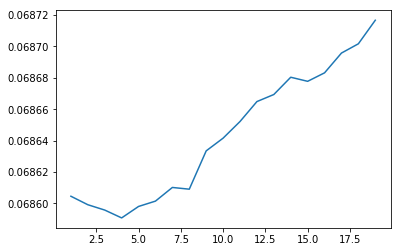

In [77]:
# print(min(results))
plt.plot(estimators, results)

__Using PCA with GradientBoostRegression doesn't help to reduce the MAE. We got 0.068703 before PCA and 0.068718 after. While it doesn't reduce MAE here, maybe it is still better for generalizability? (Maybe not, open to suggestions). PCA also reduced runtime from 20 minutes down to less than 30 seconds.__

In [ ]:
spca = SparsePCA(n_components = 10, alpha=0.5, tol=0.001)
spca.fit(train_data)
for k in range(1,11):
    explained_var = pca.explained_variance_ratio_[0:k]
    print "k=" + str(k) + ", explained variance =", sum(explained_var)

In [ ]:
spca = SparsePCA(n_components = 3, alpha=0.5, tol=0.001)
spca.fit(train_data)
train_data_spca = spca.transform(train_data) 
dev_data_spca = spca.transform(dev_data) 

estimators = range(1,25)
lowest_mae = 1
results = []
for i in estimators:
    gboost = GradientBoostingRegressor(n_estimators=i) 
    gboost.fit(train_data_spca, train_labels)
    gboost_predict = gboost.predict(dev_data_spca)

    mae = MAE(dev_labels, gboost_predict)
    results.append(mae)
    
    if mae < lowest_mae:
        lowest_mae = mae
        best_estimator = i
print "Best estimator=%d, MAE=%7.6f" % (best_estimator, lowest_mae)

In [ ]:
# print(min(results))
plt.plot(estimators, results)

__Using SparcePCA with GradientBoostRegression doesn't help to reduce the MAE either. We got 0.068703 before SparsePCA and 0.068724 after. SparsePCA performed slightly worse than regular PCA (0.068718) as well. The PCA models ran much faster, so maybe they're still useful.__

# Decision Tree Regression

In [ ]:
dtr = DecisionTreeRegressor(criterion="mae")
dtr.fit(train_data_pca, train_labels)
dtr_preds = dtr.predict(dev_data_pca)
dtr_mae = MAE(dev_labels, dtr_preds)
print 'DecisionTreeRegressor MAE =', dtr_mae

# Random Forest Regression

In [ ]:
rfr = RandomForestRegressor(criterion="mae", n_estimators=5)
rfr.fit(train_data_pca, train_labels)
rfr_preds = rfr.predict(dev_data_pca)
mae = MAE(dev_labels, rfr_preds)
print 'RandomForestRegressor MAE =', mae

# Logistic Regression

In [ ]:
# Logistic Regression

# LR1 = LogisticRegression(penalty='l2', tol=0.0001, fit_intercept=True, intercept_scaling=1
#                               , solver='newton-cg', multi_class='multinomial')
# ### GridSearchCV to find best C using l2 regularization.  
# ## Using [float(2**i)/100 for i in range(1,20) ] ...
# LR1_para = {'C': [0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28, 2.56, 5.12, 10.24, 20.48, 
#                        40.96, 81.92, 163.84, 327.68, 655.36, 1310.72, 2621.44, 5242.88] }
# LR1_GS = GridSearchCV(estimator=LR1, param_grid=LR1_para, scoring='f1', n_jobs=-1)
# LR1_GS.fit(train_data, train_labels)
# print("Start LogisticRegression:")
# print(LR1_GS.best_score_)
# print(LR1_GS.best_params_)
# # print("f1:",metrics.f1_score(dev_labels,LR1_GS.best_estimator_.predict(dev_data),average='micro'))



In [ ]:
# zipped = zip(train_df.columns, spca.components_)

In [ ]:
# spca.components_.shape

Next steps:
Check SparsePCA which features are dropped
Model different months. Drop months before PCA, do PCA, then add months back in

In [73]:
train_data_no_months = np.delete(train_data, range(111,124), axis=1)
train_months = np.delete(train_data, range(0,111), axis=1)
dev_data_no_months = np.delete(train_data, range(111,124), axis=1)
dev_months = np.delete(train_data, range(0,111), axis=1)

print train_data.shape
print train_data_no_months.shape
print train_months.shape
print ''
print dev_data.shape
print dev_data_no_months.shape
print dev_months.shape

(70000, 124)
(70000, 111)
(70000, 13)

(20275, 124)
(70000, 111)
(70000, 13)


In [74]:
# TESTING REMOVING MONTHS AND RE-ADDING
pca = PCA(n_components=3)
pca.fit(train_data_no_months)
train_data_pca = pca.transform(train_data_no_months) 
dev_data_pca = pca.transform(dev_data_no_months) 

train_data_final = np.hstack((train_data_pca, train_months))
dev_data_final = np.hstack((dev_data_pca, dev_months))

estimators = range(1,15)
lowest_mae = 1
results = []
for i in estimators:
    gboost = GradientBoostingRegressor(n_estimators=i) 
    gboost.fit(train_data_final, train_labels)
    gboost_predict = gboost.predict(dev_data_final)

    mae = MAE(dev_labels, gboost_predict)
    results.append(mae)
    
    if mae < lowest_mae:
        lowest_mae = mae
        best_estimator = i
print "Best estimator=%d, MAE=%7.6f" % (best_estimator, lowest_mae)

Best estimator=1, MAE=0.068619


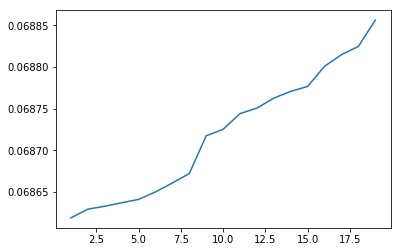

In [75]:
# print(min(results))
plt.plot(estimators, results)

In [ ]:
# gboost = GradientBoostingRegressor(n_estimators=30) 
# gboost.fit(train_data, train_labels)
# gboost_predict = gboost.predict(dev_data)

# print MAE(dev_labels, gboost_predict)
# print gboost.feature_importances_